In [3]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from a CSV file
data = pd.read_csv("C:/Users/Nithin/Desktop/Deep_Learning/Project/Code Folder/data.csv")

# Handle missing values if needed
data.dropna(inplace=True)

# Split the data into features and target
X = data.drop("target", axis=1)
y = data["target"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define a dictionary of models and their hyperparameters for tuning
models = {
    "Improved MLP": {
        "model": nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        ),
        "epochs": 50,
        "batch_size": 64,
        "optimizer": optim.Adam,
        "learning_rate": 0.001,
        "criterion": nn.BCELoss(),
        "lr_scheduler": None,
        "early_stopping": None
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "hyperparameters": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "SVM": {
        "model": SVC(random_state=42),
        "hyperparameters": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto", 0.1, 0.01]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "hyperparameters": {}
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "hyperparameters": {
            "n_neighbors": [5, 10, 15],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
    }
}

# Helper function for hyperparameter tuning
# Helper function for hyperparameter tuning
def tune_hyperparameters(model, params, X_train, y_train):
    if isinstance(model, nn.Module):  # For PyTorch models
        return model, None  # No hyperparameter tuning for PyTorch models
    elif params:  # For non-NN models with hyperparameters
        scorer = make_scorer(accuracy_score)
        clf = GridSearchCV(model, params, scoring=scorer, cv=5, n_jobs=1, verbose=1)  # Reduce n_jobs to 1
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        return best_model, clf.best_params_
    else:
        model.fit(X_train, y_train)  # Fit GaussianNB here
        return model, None

# Train and evaluate each model with hyperparameter tuning
results = []

for model_name, config in models.items():
    model, hyperparameters = tune_hyperparameters(config["model"], config.get("hyperparameters"), X_train, y_train)
    
    if isinstance(model, nn.Module):  # For PyTorch models
        model.to(torch.device("cpu"))
        criterion = config["criterion"]
        optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
        lr_scheduler = config["lr_scheduler"]
        early_stopping = config["early_stopping"]

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

        for epoch in range(config["epochs"]):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1))
                loss.backward()
                optimizer.step()
            if lr_scheduler:
                lr_scheduler.step()

            if early_stopping:
                # Implement early stopping logic here if needed
                pass

        model.eval()
        y_pred = model(X_test).detach().numpy()
        y_pred = (y_pred > 0.5).astype(float)
    else:  # For non-NN models
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Hyperparameters": hyperparameters
    })

    print(f"{model_name} Accuracy: {accuracy:.2f}")
    if hyperparameters:
        print(f"Best Hyperparameters: {hyperparameters}")
    print("\n")


Improved MLP Accuracy: 0.61


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest Accuracy: 0.85
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVM Accuracy: 0.89
Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Naive Bayes Accuracy: 0.91


Fitting 5 folds for each of 12 candidates, totalling 60 fits
K-Nearest Neighbors Accuracy: 0.81
Best Hyperparameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}




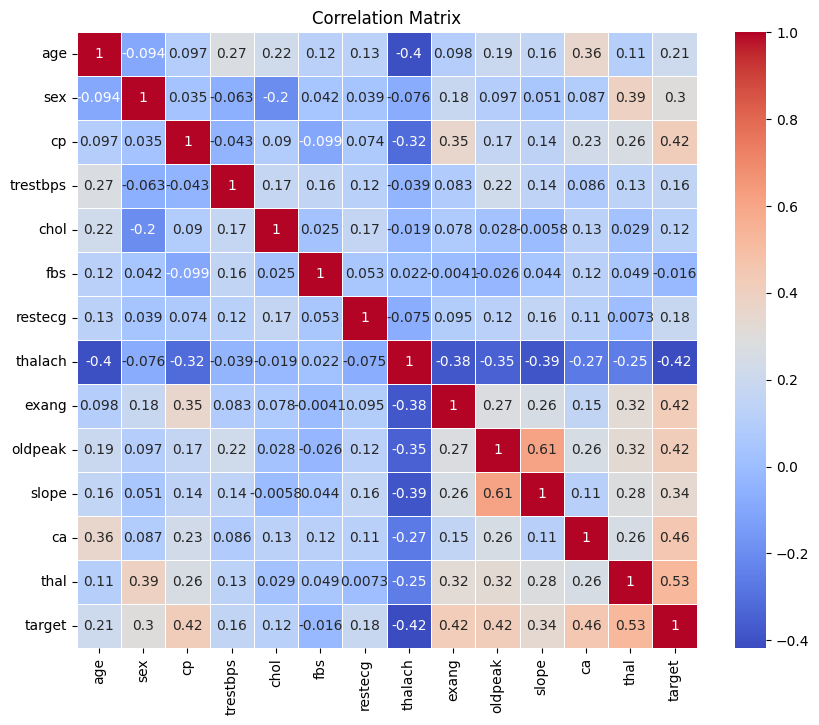

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

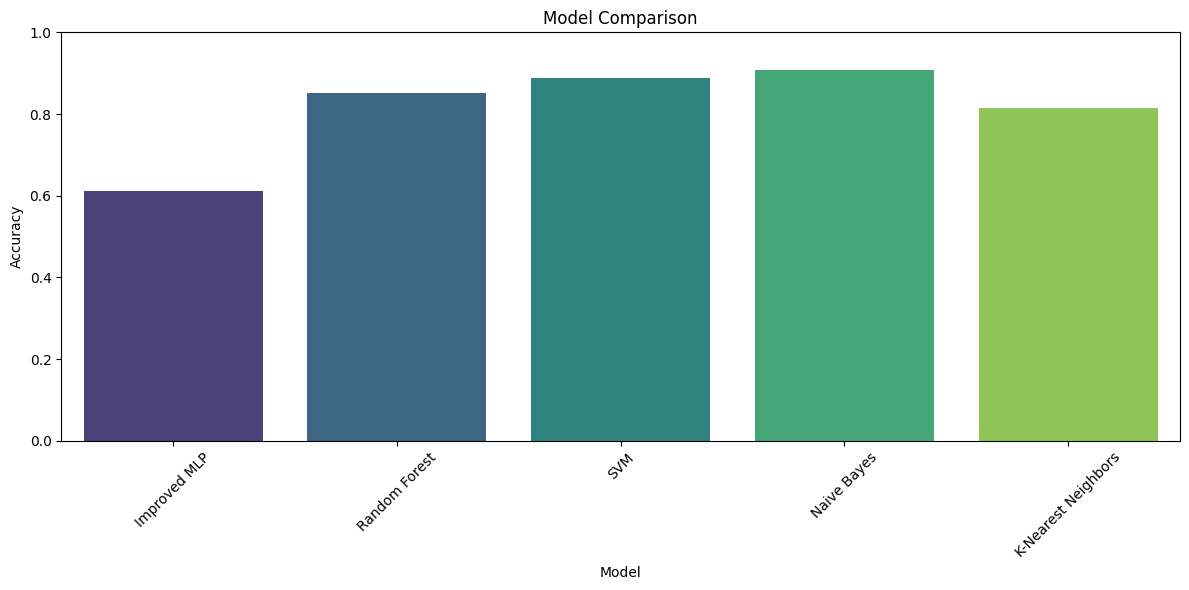

In [5]:
# Visualize the model comparison using a bar chart
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim([0, 1.0])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

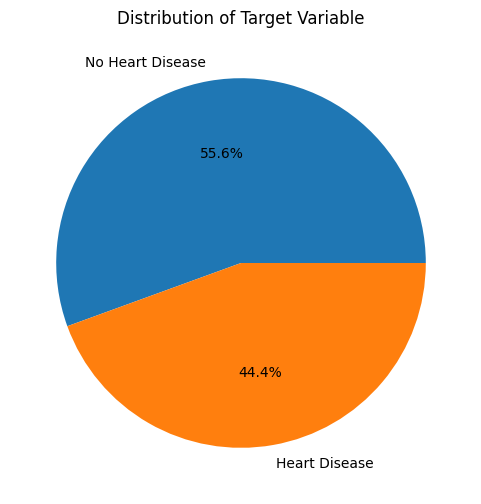

In [6]:
# Create a pie chart to show the distribution of the target variable
plt.figure(figsize=(6, 6))
data["target"].value_counts().plot.pie(autopct='%1.1f%%', labels=["No Heart Disease", "Heart Disease"])
plt.title("Distribution of Target Variable")
plt.ylabel("")
plt.show()


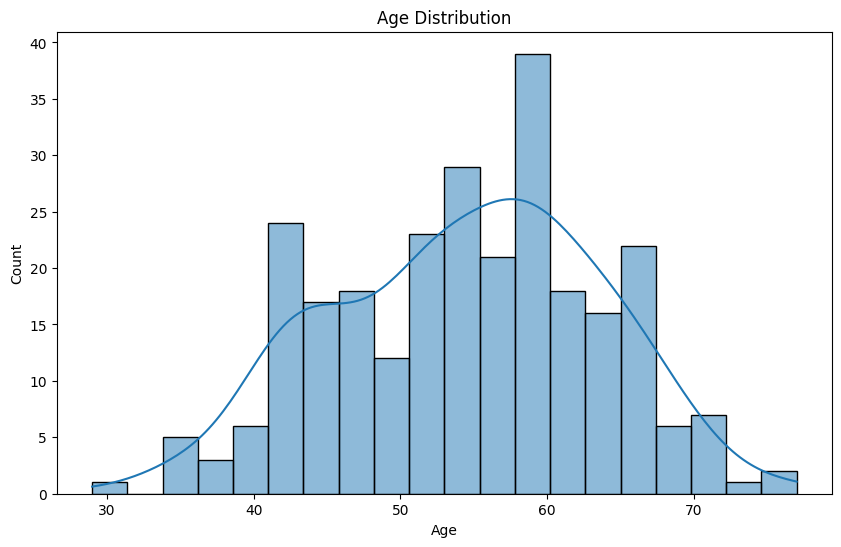

In [7]:
# Create a histogram to show the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="age", bins=20, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

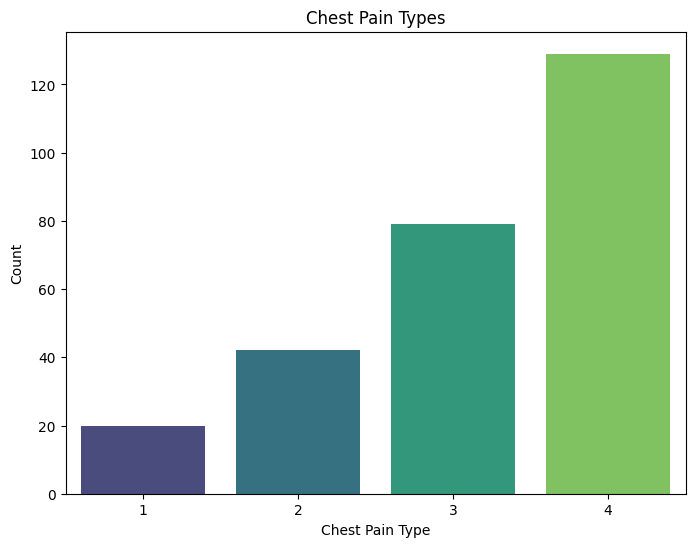

In [8]:
chest_pain_counts = data['cp'].value_counts()

# Create a bar chart for chest pain types
plt.figure(figsize=(8, 6))
sns.barplot(x=chest_pain_counts.index, y=chest_pain_counts.values, palette="viridis")
plt.title("Chest Pain Types")
plt.xlabel("Chest Pain Type")
plt.ylabel("Count")
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

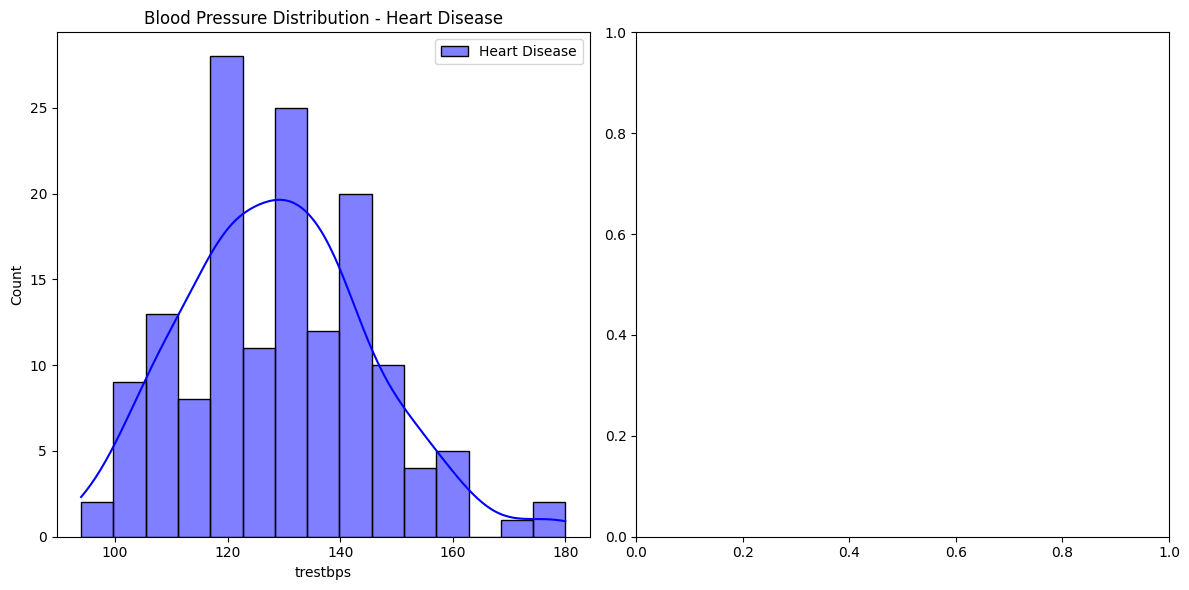

In [9]:
# Create separate dataframes for individuals with and without heart disease
heart_disease_data = data[data['target'] == 1]

# Set up the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Create histograms for blood pressure based on heart disease status
sns.histplot(heart_disease_data['trestbps'], bins=15, ax=axes[0], color='b', label='Heart Disease', kde=True)

# Set labels and titles
axes[0].set_title('Blood Pressure Distribution - Heart Disease')
axes[0].set_ylabel('Count')


# Add legends
axes[0].legend()

plt.tight_layout()
plt.show()

In [16]:
# Done After the presentation on NOV-8

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('C:/Users/Nithin/Desktop/Deep_Learning/Project/Code Folder/data.csv')

X = data.drop('target', axis=1)  # Assuming 'target' is the column to predict
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Function to train and evaluate models
def train_and_evaluate(model, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs=100):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
        predictions = (predictions > 0.5).float()
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
    
    return accuracy

# Logistic Regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        return self.sigmoid(out)

logistic_model = LogisticRegressionModel(X_train.shape[1])

criterion = nn.BCELoss()
optimizer = optim.SGD(logistic_model.parameters(), lr=0.01)

logistic_accuracy = train_and_evaluate(logistic_model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Feedforward Neural Network (similar to ANN)
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

ffnn_model = FeedForwardNN(X_train.shape[1], 128)

criterion = nn.BCELoss()
optimizer = optim.Adam(ffnn_model.parameters(), lr=0.001)  # Using Adam optimizer

ffnn_accuracy = train_and_evaluate(ffnn_model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

X = data.drop('target', axis=1)  # Features
y = data['target']  # Target variable

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training an Artificial Neural Network 
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

y_pred_ann = mlp.predict(X_test)
accuracy_ann = accuracy_score(y_test, y_pred_ann)
print("ANN Accuracy: {:.2f}%".format(accuracy_ann * 100))


# Simple Recurrent Neural Network (RNN)
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

rnn_model = SimpleRNN(X_train.shape[1], 64)

criterion = nn.BCELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)  # Using Adam optimizer

# Reshape data for RNN
X_train_rnn = X_train_tensor.view(-1, 1, X_train_tensor.shape[1])
X_test_rnn = X_test_tensor.view(-1, 1, X_test_tensor.shape[1])

rnn_accuracy = train_and_evaluate(rnn_model, criterion, optimizer, X_train_rnn, y_train_tensor, X_test_rnn, y_test_tensor)

# Compare accuracies
accuracies = {
    'Logistic Regression': logistic_accuracy,
    'Feedforward NN': ffnn_accuracy,
    'RNN': rnn_accuracy
}

# Train Logistic Regression model
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)

# Predict using Logistic Regression model
y_pred_log_reg = logistic_regression.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy: {:.2f}%".format(accuracy_log_reg * 100))


best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"Accuracy of RNN: {rnn_accuracy:.2f}")

ANN Accuracy: 85.19%
Logistic Regression Accuracy: 90.74%
Accuracy of RNN: 0.41
